Dans ce notebook, vous apprendrez à classer des images de chats et de chiens en utilisant un transfert learning à partir d'un réseau pré-entraîné sur le jeu de données [ImageNet](https://www.image-net.org/update-mar-11-2021.php).

# Importation des données

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import os

import urllib.request
import zipfile

import torch
from torchvision import datasets, transforms
from torchsummary import summary

# Chargement des données

Téléchargement des données

In [34]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
urllib.request.urlretrieve(_URL, "cats_and_dogs.zip")

('cats_and_dogs.zip', <http.client.HTTPMessage at 0x794600a3b4c0>)

Unzip du fichier.

In [35]:
with zipfile.ZipFile("cats_and_dogs.zip", 'r') as zip_ref:
    zip_ref.extractall()

In [36]:
PATH = "cats_and_dogs_filtered"

Sauvegarde des PATH

In [37]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

# Fixer les hyperparamètres

In [38]:
BATCH_SIZE = 32
IMG_SIZE = (128, 128)

# Initialiser les générateurs

Pour le jeu d'entraînement.

In [39]:
transform = transforms.Compose([transforms.Resize(IMG_SIZE),
                                 transforms.ToTensor()])

In [40]:
dataset_train = datasets.ImageFolder(train_dir,
                               transform=transform)

In [41]:
dataloader_train = torch.utils.data.DataLoader(dataset_train,
                                         batch_size=32,
                                         shuffle=True)

torch.Size([32, 3, 128, 128])
torch.Size([32])


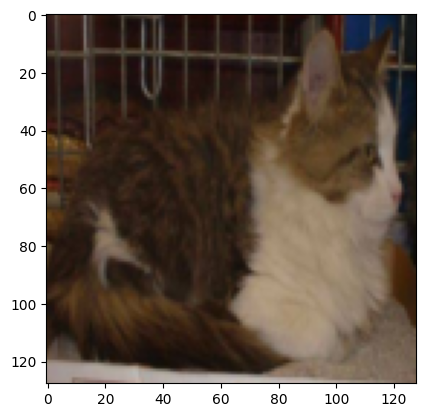

In [42]:
for x, y in dataloader_train:
    print(x.shape)
    print(y.shape)
    plt.imshow(np.transpose(x[0, :, :, :].squeeze(), (1, 2, 0)), cmap='gray')
    plt.show()
    break

Pour le jeu de validation.

In [43]:
dataset_test = datasets.ImageFolder(validation_dir,
                               transform=transform)

dataloader_test = torch.utils.data.DataLoader(dataset_test,
                                         batch_size=32,
                                         shuffle=True)

torch.Size([32, 3, 128, 128])
torch.Size([32])


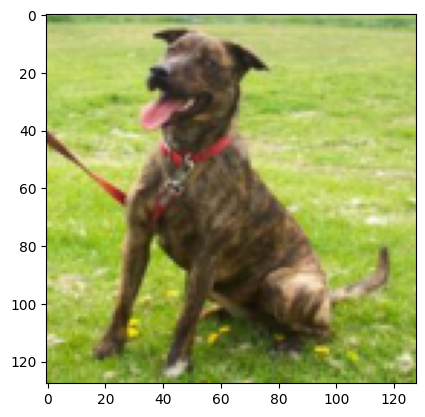

In [44]:
for x, y in dataloader_test:
    print(x.shape)
    print(y.shape)
    plt.imshow(np.transpose(x[0, :, :, :].squeeze(), (1, 2, 0)), cmap='gray')
    plt.show()
    break

#  Charger un modèle pré-entraîné

List de modèles https://pytorch.org/vision/stable/models.html#classification

In [45]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (3,) + IMG_SIZE
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Regarder la dimension de ce que le modèle nous retourne à partir de nos images en (160, 160, 3).

In [46]:
summary(model, IMG_SHAPE, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             864
       BatchNorm2d-2           [-1, 32, 64, 64]              64
             ReLU6-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]             288
       BatchNorm2d-5           [-1, 32, 64, 64]              64
             ReLU6-6           [-1, 32, 64, 64]               0
            Conv2d-7           [-1, 16, 64, 64]             512
       BatchNorm2d-8           [-1, 16, 64, 64]              32
  InvertedResidual-9           [-1, 16, 64, 64]               0
           Conv2d-10           [-1, 96, 64, 64]           1,536
      BatchNorm2d-11           [-1, 96, 64, 64]             192
            ReLU6-12           [-1, 96, 64, 64]               0
           Conv2d-13           [-1, 96, 32, 32]             864
      BatchNorm2d-14           [-1, 96,

In [47]:
feature_batch = model(x)

In [48]:
feature_batch.shape

torch.Size([32, 1000])

Le modèle est décomposé en une partie feature et une partie classifier.

In [49]:
model

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

La partie classifier est décomposé en une couche de drop out et une couche linéaire.

In [50]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

La couche reçoit en entrée 1280 variables.

In [51]:
model.classifier[1].in_features

1280

On le remplace par une couche qui reçoit la même chose mais qui n'aura qu'une neurone en sortie car nous allons faire la différence entre un chien et un chat.

In [52]:
model.classifier[0] = torch.nn.Linear(model.classifier[1].in_features, 2)
model.classifier[1] = torch.nn.LogSoftmax(dim=1)

La modification a bien été effectué.

In [53]:
model.classifier

Sequential(
  (0): Linear(in_features=1280, out_features=2, bias=True)
  (1): LogSoftmax(dim=1)
)

Visualisez le modèle maintenant.

In [54]:
summary(model, (3, 128, 128), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             864
       BatchNorm2d-2           [-1, 32, 64, 64]              64
             ReLU6-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]             288
       BatchNorm2d-5           [-1, 32, 64, 64]              64
             ReLU6-6           [-1, 32, 64, 64]               0
            Conv2d-7           [-1, 16, 64, 64]             512
       BatchNorm2d-8           [-1, 16, 64, 64]              32
  InvertedResidual-9           [-1, 16, 64, 64]               0
           Conv2d-10           [-1, 96, 64, 64]           1,536
      BatchNorm2d-11           [-1, 96, 64, 64]             192
            ReLU6-12           [-1, 96, 64, 64]               0
           Conv2d-13           [-1, 96, 32, 32]             864
      BatchNorm2d-14           [-1, 96,

Fixer le modèle de base pour que les poids ne soient pas mis-à-jour.

In [55]:
for param in model.features.parameters():
    param.requires_grad = False

Vous pouvez maintenant regarder le nombre de parmètres entrainable qui ne correspond qu'à la dernière ligne.

In [56]:
summary(model, IMG_SHAPE, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             864
       BatchNorm2d-2           [-1, 32, 64, 64]              64
             ReLU6-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]             288
       BatchNorm2d-5           [-1, 32, 64, 64]              64
             ReLU6-6           [-1, 32, 64, 64]               0
            Conv2d-7           [-1, 16, 64, 64]             512
       BatchNorm2d-8           [-1, 16, 64, 64]              32
  InvertedResidual-9           [-1, 16, 64, 64]               0
           Conv2d-10           [-1, 96, 64, 64]           1,536
      BatchNorm2d-11           [-1, 96, 64, 64]             192
            ReLU6-12           [-1, 96, 64, 64]               0
           Conv2d-13           [-1, 96, 32, 32]             864
      BatchNorm2d-14           [-1, 96,

# Les fonctions d'entraînement

In [57]:
def number_of_good_prediction(prediction:float, target:int):
  one_hot_prediction = np.argmax(prediction, axis=1)
  return np.sum(one_hot_prediction == target)

In [58]:
def save_model(model, path):
    torch.save(model.state_dict(), path)

In [59]:
def step(model:torch.nn.Sequential,
         opt:torch.optim,
         criterion:torch.nn.modules.loss,
         x_train:torch.Tensor,
         y_train:torch.Tensor,
         metric_function)->tuple:
  """
  Executes a single training step for a PyTorch model.
  This function performs a forward pass to compute the model's predictions, calculates
  the loss between predictions and actual target values, computes gradients for each
  model parameter, and updates the parameters using the optimizer.

  Args:
      model (torch.nn.Sequential): The PyTorch model to train.
      optimizer (torch.optim.Optimizer): Optimizer used to update the model's parameters.
      criterion (torch.nn.modules.loss._Loss): Loss function used to compute the error.
      x_train (torch.Tensor): Input training data (features).
      y_train (torch.Tensor): Ground truth labels or target values for the training data.
  Returns:
      tuple: The updated model and the computed loss for the current step.
  """

  # Réinitialisez les gradients d'optimizer à zéro avec la méthode 'zero_grad'
  opt.zero_grad()

  # Calculez les prédiction sur le jeu d'entraînement avec la méthode 'froward'
  prediction = model.forward(x_train)

  # Calculez l'erreur de prédiction avec 'criterion'
  loss = criterion(prediction, y_train)

  performance = metric_function(prediction.detach().numpy(), y_train.detach().numpy())

  # Calculez les gradients avec la méthode 'backward'
  loss.backward()

  # Mettre à jour les paramètres du modèle avec la méthode 'step'
  opt.step()

  return model, loss, performance

In [60]:
def fit(model, optimizer, criterion, epoch, trainloader, testloader, metric_function):
    epoch = epoch
    history_train_loss = []
    history_test_loss = []
    history_train_metrics = []
    history_test_metrics = []

    reference_performance = 0

    for e in range(epoch) :

      train_loss_batch = 0
      test_loss_batch = 0
      train_metric_batch = 0
      test_metric_batch = 0

      for images, labels in trainloader:

        # mise à jour des poids avec la fonction 'step'
        model, train_loss, train_performance = step(model, optimizer, criterion, images, labels, metric_function)

        train_loss_batch += train_loss.detach().numpy()

        train_metric_batch += train_performance


      for images, labels in testloader:

        prediction = model.forward(images)

        test_loss = criterion(prediction, labels)

        test_metric_batch += metric_function(prediction.detach().numpy(), labels.detach().numpy())

        test_loss_batch += test_loss.detach().numpy()

      train_loss_batch /= len(trainloader.sampler)
      test_loss_batch /= len(testloader.sampler)

      train_metric_batch /= len(trainloader.sampler)
      test_metric_batch /= len(testloader.sampler)

      # Sauvegarde des coûts d'entraînement avec append
      history_train_loss = np.append(history_train_loss, train_loss_batch)
      history_test_loss = np.append(history_test_loss, test_loss_batch)

      # Sauvegarde des coûts d'entraînement avec append
      history_train_metrics = np.append(history_train_metrics, train_metric_batch)
      history_test_metrics = np.append(history_test_metrics, test_metric_batch)

      print('train_loss : '+str(np.squeeze(train_loss_batch))+ ' test_loss : '+str(np.squeeze(test_loss_batch)))
      print('train_metric : '+str(np.squeeze(train_metric_batch))+ ' test_metric : '+str(np.squeeze(test_metric_batch)))
      print('-------------------------------------------------------------------------------------------------')

      if test_metric_batch > reference_performance:
        reference_performance = test_metric_batch
        save_model(model, f'best_model_{test_metric_batch}.pth')

    return model, history_train_loss, history_test_loss, history_train_metrics, history_test_metrics


# Compiler le modèle

Initialisez `criterion` avec la fonction `NLLLoss`.

Initialisez `optimizer` avec `Adam` et un learning rate de 0.001.

In [61]:
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Entraînement du modèle

In [62]:
epoch = 5

model, history_train_loss, history_test_loss, history_train_metrics, history_test_metrics = fit(model,
                                                                                        optimizer,
                                                                                        criterion,
                                                                                        epoch,
                                                                                        dataloader_train,
                                                                                        dataloader_test,
                                                                                        number_of_good_prediction)

train_loss : 0.010914558172225952 test_loss : 0.007328095838427543
train_metric : 0.838 test_metric : 0.907
-------------------------------------------------------------------------------------------------
train_loss : 0.007734216678887605 test_loss : 0.007068223424255848
train_metric : 0.8975 test_metric : 0.91
-------------------------------------------------------------------------------------------------
train_loss : 0.0068633266128599645 test_loss : 0.006753639377653599
train_metric : 0.91 test_metric : 0.908
-------------------------------------------------------------------------------------------------
train_loss : 0.006721683349460363 test_loss : 0.006670006133615971
train_metric : 0.9085 test_metric : 0.907
-------------------------------------------------------------------------------------------------
train_loss : 0.006238596454262733 test_loss : 0.006524760842323303
train_metric : 0.913 test_metric : 0.917
-------------------------------------------------------------------

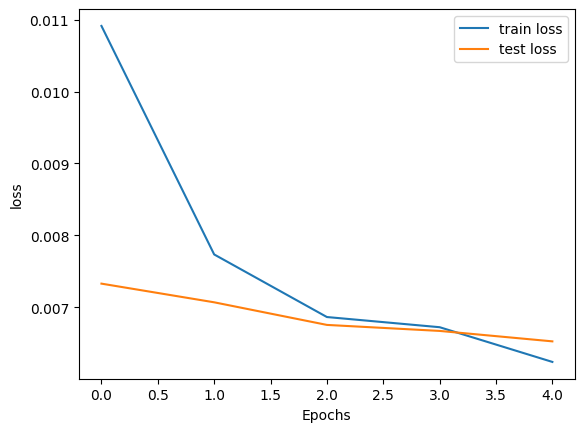

In [63]:
plt.plot(np.arange(epoch), history_train_loss, label='train loss')
plt.plot(np.arange(epoch), history_test_loss, label='test loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend(loc='upper left')
plt.legend()
plt.show()

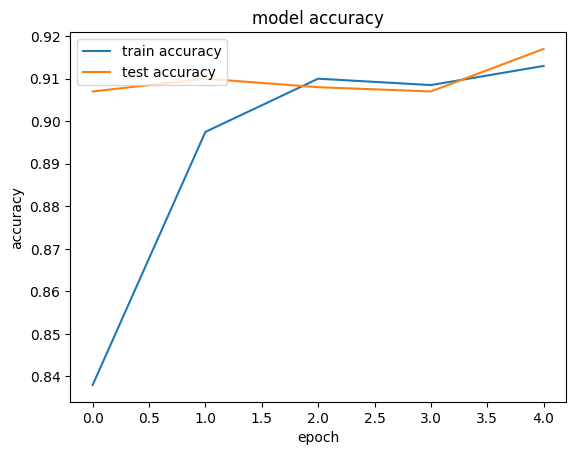

In [64]:
plt.plot(history_train_metrics, label='train accuracy')
plt.plot(history_test_metrics, label='test accuracy')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

# Fine tuning

Entraîner tous les paramètres du modèle.

In [65]:
for param in model.features.parameters():
    param.requires_grad = True

Utilisez `summary` pour visualiser le nombre de paramètre entraînable du modèle maintenant.

In [66]:
summary(model, (3, 128, 128), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             864
       BatchNorm2d-2           [-1, 32, 64, 64]              64
             ReLU6-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]             288
       BatchNorm2d-5           [-1, 32, 64, 64]              64
             ReLU6-6           [-1, 32, 64, 64]               0
            Conv2d-7           [-1, 16, 64, 64]             512
       BatchNorm2d-8           [-1, 16, 64, 64]              32
  InvertedResidual-9           [-1, 16, 64, 64]               0
           Conv2d-10           [-1, 96, 64, 64]           1,536
      BatchNorm2d-11           [-1, 96, 64, 64]             192
            ReLU6-12           [-1, 96, 64, 64]               0
           Conv2d-13           [-1, 96, 32, 32]             864
      BatchNorm2d-14           [-1, 96,

Compiler le nouveau modèle

In [67]:
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Continuer l'entraînement du modèle avec toutes les couches entrainables.

In [68]:
epoch = 5

model, history_train_loss_2, history_test_loss_2, history_train_metrics_2, history_test_metrics_2 = fit(model,
                                                                                                        optimizer,
                                                                                                        criterion,
                                                                                                        epoch,
                                                                                                        dataloader_train,
                                                                                                        dataloader_test,
                                                                                                        number_of_good_prediction)

train_loss : 0.014067405816167593 test_loss : 0.006362794380635023
train_metric : 0.854 test_metric : 0.923
-------------------------------------------------------------------------------------------------
train_loss : 0.00508227740926668 test_loss : 0.006144330289214849
train_metric : 0.932 test_metric : 0.934
-------------------------------------------------------------------------------------------------
train_loss : 0.0028195911962538957 test_loss : 0.006132917478680611
train_metric : 0.9685 test_metric : 0.924
-------------------------------------------------------------------------------------------------
train_loss : 0.002395012243767269 test_loss : 0.007700377620756626
train_metric : 0.9695 test_metric : 0.918
-------------------------------------------------------------------------------------------------
train_loss : 0.0018620035203639417 test_loss : 0.008699578359723091
train_metric : 0.9755 test_metric : 0.925
----------------------------------------------------------------

Concatenation des vecteurs de résultats.

In [69]:
loss = np.concatenate([history_train_loss, history_train_loss_2])
val_loss = np.concatenate([history_test_loss, history_test_loss_2])

perf = np.concatenate([history_train_metrics, history_train_metrics_2])
val_perf = np.concatenate([history_test_metrics, history_test_metrics_2])

Visualiser les performances

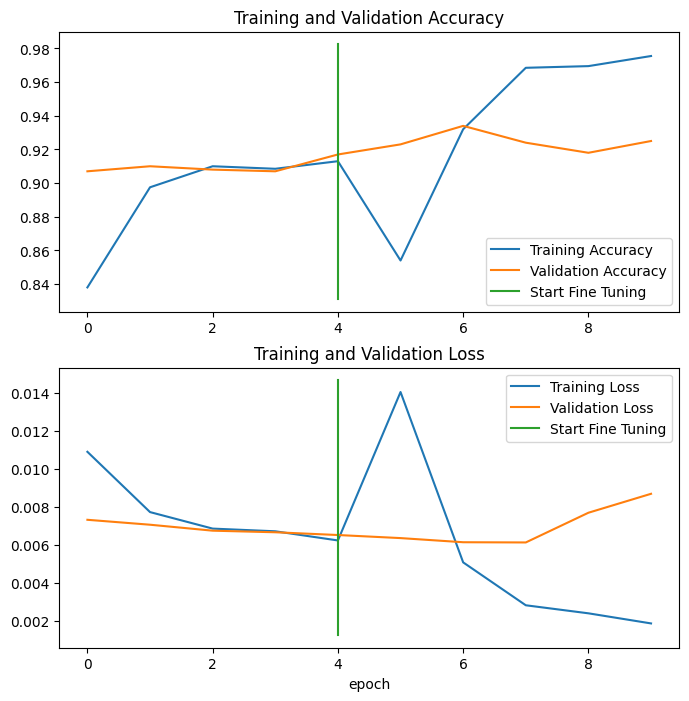

In [73]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(perf, label='Training Accuracy')
plt.plot(val_perf, label='Validation Accuracy')
#plt.ylim([0.8, 1])
plt.plot([epoch-1,epoch-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
#plt.ylim([0, 1.0])
plt.plot([epoch-1,epoch-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()